In [1]:
import drawing_system_dev as ds
import copy
from test_strings import room_sizes, area_types, user_constraints

In [2]:
# Run the processing pipeline
constraints, room_name_mappings = ds.get_constraints_room_mappings(user_constraints, room_sizes)

Constraints: [{'type': 'bedroom_1', 'size': 12}, {'type': 'bedroom_2', 'size': 9}, {'type': 'bedroom_3', 'size': 9}, {'type': 'bedroom_4', 'size': 9}, {'type': 'bathroom_1', 'size': 5}, {'type': 'bathroom_2', 'size': 5}, {'type': 'bathroom_3', 'size': 5}, {'type': 'kitchen_1', 'size': 8}, {'type': 'kitchen_2', 'size': 8}, {'type': 'garage_1', 'size': 6}]
Room Name Mappings: {'bedroom_1': 'bedroom_1', 'bedroom_2': 'bedroom_2', 'bedroom_3': 'bedroom_3', 'bedroom_4': 'bedroom_4', 'bathroom_1': 'bathroom_1', 'bathroom_2': 'bathroom_2', 'bathroom_3': 'bathroom_3', 'kitchen_1': 'kitchen_1', 'kitchen_2': 'kitchen_2', 'garage_1': 'garage_1'}


In [3]:
grouped_rooms = ds.group_rooms(constraints, area_types)
grouped_rooms

{'social': [{'name': 'livingroom_1', 'size': 12},
  {'name': 'garage_1', 'size': 6}],
 'service': [{'name': 'kitchen_1', 'size': 8},
  {'name': 'kitchen_2', 'size': 8}],
 'private': [{'name': 'bedroom_1', 'size': 12},
  {'name': 'bedroom_2', 'size': 9},
  {'name': 'bedroom_3', 'size': 9},
  {'name': 'bedroom_4', 'size': 9},
  {'name': 'bathroom_1', 'size': 5},
  {'name': 'bathroom_2', 'size': 5},
  {'name': 'bathroom_3', 'size': 5}]}

In [4]:
squarified_areas = ds.squarify_areas(grouped_rooms)
squarified_areas

[{'x': 0, 'y': 0, 'dx': 38.63636363636364, 'dy': 52.94117647058823},
 {'x': 0,
  'y': 52.94117647058823,
  'dx': 38.63636363636364,
  'dy': 47.05882352941176},
 {'x': 38.63636363636364, 'y': 0, 'dx': 61.36363636363636, 'dy': 100.0}]

In [5]:
adjacency_requirement = ds.get_adjacency_requirements(user_constraints, room_sizes)
adjacency_requirement

[['bedroom_1', 'kitchen_1'],
 ['bedroom_1', 'bathroom_1'],
 ['bedroom_2', 'livingroom_1'],
 ['bedroom_3', 'livingroom_1'],
 ['bedroom_4', 'livingroom_1'],
 ['bedroom_2', 'bathroom_2'],
 ['bedroom_3', 'bathroom_3'],
 ['garage_1', 'livingroom_1']]

In [6]:
room_data, graph = ds.get_room_data_and_graph(grouped_rooms, squarified_areas)

In [7]:
room_data

{0: {'label': 'livingroom_1',
  'rect': {'x': 0, 'y': 0, 'dx': 38.63636363636364, 'dy': 35.29411764705882},
  'adjacent_rooms': [1, 4]},
 1: {'label': 'garage_1',
  'rect': {'x': 0,
   'y': 35.29411764705882,
   'dx': 38.63636363636363,
   'dy': 17.647058823529413},
  'adjacent_rooms': [0, 2, 4, 6]},
 2: {'label': 'kitchen_1',
  'rect': {'x': 0,
   'y': 52.94117647058823,
   'dx': 38.63636363636364,
   'dy': 23.52941176470588},
  'adjacent_rooms': [1, 3, 6, 7]},
 3: {'label': 'kitchen_2',
  'rect': {'x': 0,
   'y': 76.47058823529412,
   'dx': 38.63636363636364,
   'dy': 23.52941176470588},
  'adjacent_rooms': [2, 7]},
 4: {'label': 'bedroom_1',
  'rect': {'x': 38.63636363636364,
   'y': 0,
   'dx': 35.064935064935064,
   'dy': 38.888888888888886},
  'adjacent_rooms': [0, 1, 5, 6]},
 5: {'label': 'bedroom_2',
  'rect': {'x': 73.7012987012987,
   'y': 0,
   'dx': 26.2987012987013,
   'dy': 38.888888888888886},
  'adjacent_rooms': [4, 8]},
 6: {'label': 'bedroom_3',
  'rect': {'x': 38.636

In [8]:
swappable_rooms = ds.get_swappable_rooms(room_data)
swappable_rooms

[(2, 3), (4, 5), (6, 7), (8, 9), (9, 10)]

In [9]:
best_room_data, best_score = ds.optimize_adjacency(room_data, adjacency_requirement)

Trying swap (2, 3): Score = 1
Trying swap (4, 5): Score = 1
Trying swap (6, 7): Score = 1
Trying swap (8, 9): Score = 2
Trying swap (9, 10): Score = 2

✅ Best swap: (8, 9) — New Score: 2
Swapped room 'bathroom_1' with 'bathroom_2'
New positions:
bathroom_1: {'x': 72.10743801652893, 'y': 59.25925925925925, 'dx': 27.892561983471076, 'dy': 20.370370370370367}
bathroom_2: {'x': 72.10743801652893, 'y': 38.888888888888886, 'dx': 27.892561983471076, 'dy': 20.370370370370367}


In [10]:
best_score

2

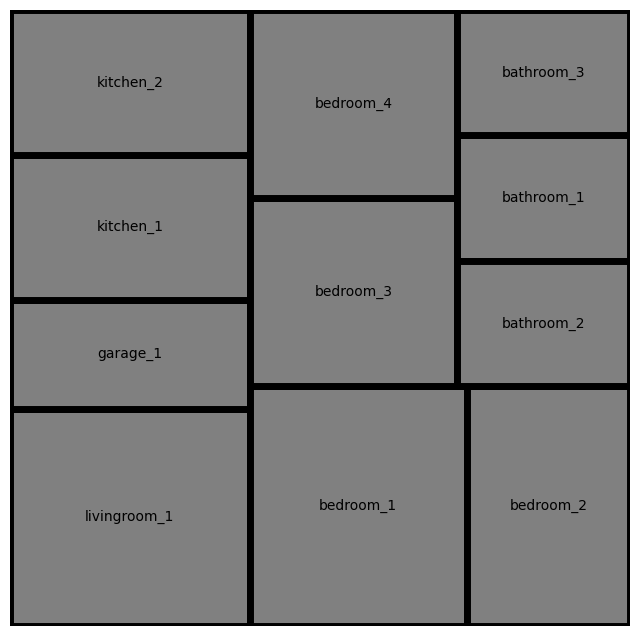

In [11]:
ds.plot_treemap(best_room_data)

removed edge: ['livingroom_1', 'garage_1']
removed edge: ['livingroom_1', 'bedroom_1']


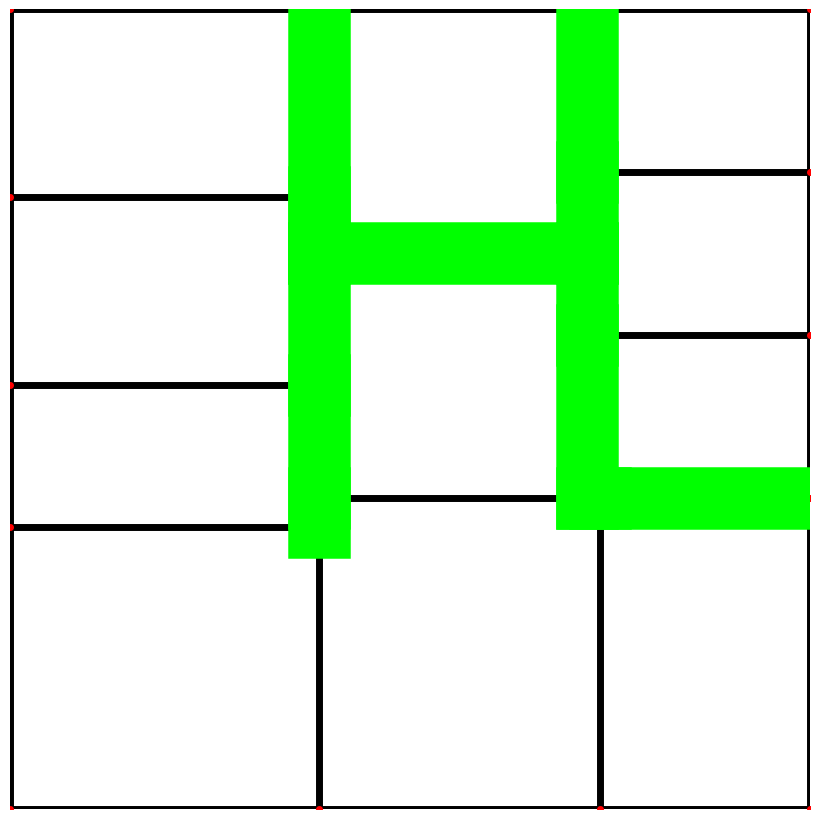

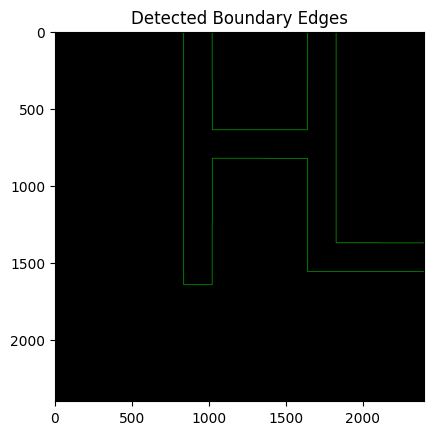

Detected Boundary Edges (as edges): [((834, 0), (834, 1645)), ((834, 1645), (1019, 1645)), ((1019, 1645), (1020, 825)), ((1020, 825), (1638, 826)), ((1638, 826), (1638, 1559)), ((1638, 1559), (2399, 1559)), ((2399, 1559), (2399, 1374)), ((2399, 1374), (1823, 1373)), ((1823, 1373), (1823, 0)), ((1823, 0), (1638, 0)), ((1638, 0), (1637, 640)), ((1637, 640), (1020, 640)), ((1020, 640), (1019, 0)), ((1019, 0), (834, 0))]
Normalized Boundary Edges (100x100 scale):
2


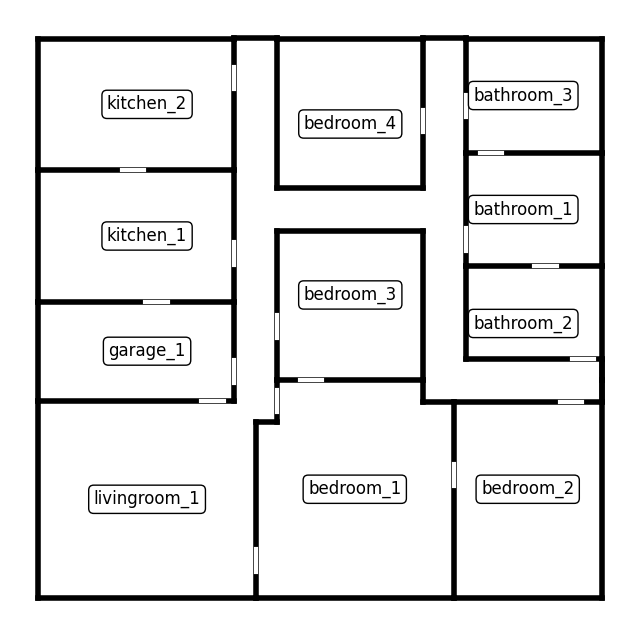

In [12]:
label_positions = ds.get_room_label_positions(best_room_data)
room_data_backbone = copy.deepcopy(best_room_data)
room_data_backbone = ds.convert_to_absolute(room_data_backbone)
graph_data = ds.convert_to_graph_with_room_info(room_data_backbone)
updated_graph_data = ds.remove_outside_edges_and_corners(graph_data)
new_graph, connecting_vertices = ds.remove_room(updated_graph_data, "livingroom_1")

disconnected_rooms = ds.get_disconnected_rooms(best_room_data)
shortest_path_graph = ds.shortest_path_to_connect_rooms(new_graph, connecting_vertices[0][0], disconnected_rooms)
cleaned_path = ds.remove_redundant_edges(shortest_path_graph)
ds.plot_graph_with_path(graph_data, cleaned_path, corridor_width=45, padding=0)
boundary_edges = ds.get_color_boundary_edges(image_path="corridor.png")
normalized_edges = ds.resize_graph_edges(original_graph_edges=boundary_edges, original_size=2400, new_size=100)
merged_normalized_edges = ds.merge_close_values_in_graph(normalized_edges)

corridor_edges_dict = ds.format_corridor_edges(merged_normalized_edges)
merged_edges = {**graph_data['edges'], **corridor_edges_dict}
split_edges_new = ds.split_edges_at_intersections(merged_edges)
unique_edges = ds.remove_duplicate_edges(split_edges_new)
room_edges_in_corridor, corridor_polygon = ds.get_room_edges_within_corridor(merged_normalized_edges, unique_edges)

corridor_edges, room_edges = ds.get_room_and_corridor_edges(unique_edges)
corridor_edges_in_rooms = ds.get_corridor_edges_within_rooms(room_edges, corridor_edges)

updated_edges = ds.remove_given_edges(unique_edges, room_edges_in_corridor)
updated_edges_removed_corridor_from_living_room = ds.remove_corridor_edges_from_living_room(updated_edges, corridor_edges_in_rooms)
room_edges_with_corridor_connection = ds.get_room_edges_with_corridor_connection(corridor_edges_in_rooms, updated_edges_removed_corridor_from_living_room)

door_edges = ds.generate_door_edges(room_edges_with_corridor_connection)

# Generate and save the final floorplan image
save_path = "final_floorplan.png"
ds.plot_graph_edges_with_doors(room_edges_with_corridor_connection, door_edges, label_positions, text_size=12, padding=5, save_path=save_path)

In [13]:
room_edges_with_corridor_connection

{((0, 0), (38.636364, 0)): ['livingroom_1'],
 ((38.636364, 0), (38.636364, 31.458333333333332)): ['livingroom_1',
  'bedroom_1'],
 ((0, 35.294118), (34.75, 35.294118)): ['livingroom_1', 'garage_1'],
 ((0, 0), (0, 35.294118)): ['livingroom_1'],
 ((0, 52.941176), (34.75, 52.941176)): ['garage_1', 'kitchen_1'],
 ((0, 35.294118), (0, 52.941176)): ['garage_1'],
 ((0, 76.470588), (34.75, 76.470588)): ['kitchen_1', 'kitchen_2'],
 ((0, 52.941176), (0, 76.470588)): ['kitchen_1'],
 ((0, 100.0), (34.75, 100.0)): ['kitchen_2'],
 ((0, 76.470588), (0, 100.0)): ['kitchen_2'],
 ((38.636364, 0), (73.701299, 0)): ['bedroom_1'],
 ((73.701299, 0), (73.701299, 35.04166666666667)): ['bedroom_1', 'bedroom_2'],
 ((42.45833333333333, 38.888889),
  (68.20833333333334, 38.888889)): ['bedroom_1', 'bedroom_3'],
 ((73.701299, 0), (100.0, 0)): ['bedroom_2'],
 ((100.0, 0), (100.0, 38.888889)): ['bedroom_2'],
 ((99.95833333333334, 38.888889), (100.0, 38.888889)): ['bedroom_2',
  'bathroom_2'],
 ((42.45833333333333, 10

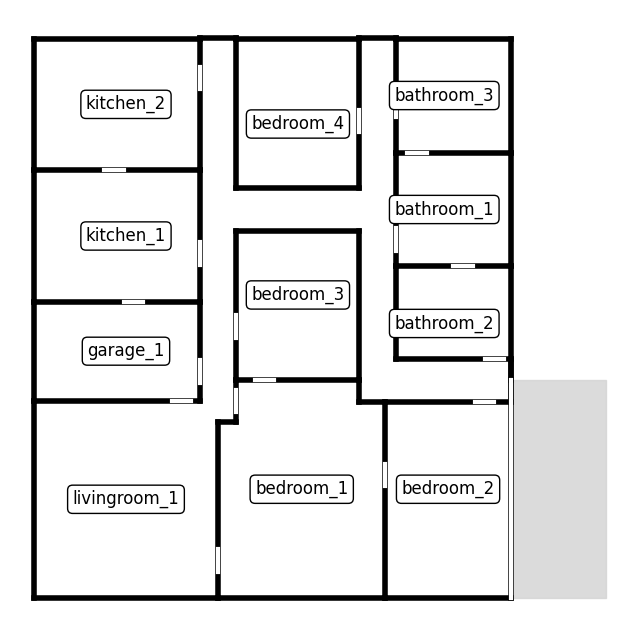

In [20]:
# Corrected code (only call once with all required arguments)
room_to_add_balcony = "bedroom_2"
balconies, new_door = ds.add_balcony_to_room(
    room_to_add_balcony,
    room_edges_with_corridor_connection,
    label_positions=label_positions,
    balcony_depth=20
)

# Merge new door
door_edges.update(new_door)

# Plot everything
ds.plot_graph_edges_with_doors(
    edges_dict=room_edges_with_corridor_connection,
    door_edges=door_edges,
    label_positions=label_positions,
    balconies=balconies
)
